## Multiple Chronic Conditions Machine Learning Modeling

### Import relevant libraries

### Load MCC Datasets

In [3]:
# Load MCC specific data
mcc_df = pd.read_csv("ml_processed_mcc_data_2017_2018.csv")

### Data Exploration

In [4]:
mcc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5858 entries, 0 to 5857
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Bene_Geo_Lvl              5858 non-null   object 
 1   Bene_Geo_Desc             5858 non-null   object 
 2   Bene_Geo_Cd               5786 non-null   float64
 3   Bene_Age_Lvl              5858 non-null   object 
 4   Bene_Demo_Lvl             5858 non-null   object 
 5   Bene_Demo_Desc            5858 non-null   object 
 6   Bene_MCC                  5858 non-null   object 
 7   Prvlnc                    5858 non-null   float64
 8   Tot_Mdcr_Stdzd_Pymt_PC    5858 non-null   float64
 9   Tot_Mdcr_Pymt_PC          5858 non-null   float64
 10  Hosp_Readmsn_Rate         5858 non-null   float64
 11  ER_Visits_Per_1000_Benes  5710 non-null   float64
 12  year                      5858 non-null   int64  
 13  Age_Group                 5858 non-null   int64  
 14  Sex     

In [5]:
mcc_df.head()

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_MCC,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,...,year,Age_Group,Sex,Medicare_Type,Non-Hispanic_White,Non-Hispanic_Black,Hispanic,Asian_Pacific_Islander,Native_American,MCC_Group
0,State,Alabama,1.0,65+,Dual Status,Medicare Only,0 to 1,0.2473,1982.6565,1790.6022,...,2017,1,-1,0,-1,-1,-1,-1,-1,0
1,State,Alabama,1.0,65+,Dual Status,Medicare Only,2 to 3,0.3028,5113.1152,4665.4711,...,2017,1,-1,0,-1,-1,-1,-1,-1,1
2,State,Alabama,1.0,65+,Dual Status,Medicare Only,4 to 5,0.2578,9650.4733,8806.6521,...,2017,1,-1,0,-1,-1,-1,-1,-1,2
3,State,Alabama,1.0,65+,Dual Status,Medicare Only,6+,0.1921,26061.1230,23776.4190,...,2017,1,-1,0,-1,-1,-1,-1,-1,3
4,State,Alabama,1.0,65+,Dual Status,Medicare and Medicaid,2 to 3,0.2236,5864.6106,5306.2806,...,2017,1,-1,1,-1,-1,-1,-1,-1,1


### ML Modeling

#### Create data splits

In [6]:
X = mcc_df.drop('Hosp_Readmsn_Rate', axis=1).copy()
y = mcc_df['Hosp_Readmsn_Rate'].copy()

In [7]:
# Create main split of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [8]:
X_train.shape

(4686, 21)

In [9]:
X_test.shape

(1172, 21)

#### Define input features

In [10]:
ml_input_feats = ['Age_Group', 'Sex', 'Medicare_Type', 'Non-Hispanic_White', 'Non-Hispanic_Black', 'Hispanic', 'Native_American', 'MCC_Group']

#### Random Forest Model

In [11]:
rf_best_params = {'n_estimators': 485, 'min_samples_split': 2, 'min_samples_leaf': 1,
                  'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': False}

In [12]:
rf_model2 = RandomForestRegressor(**rf_best_params,random_state=50)

In [13]:
%%time
rf_model2.fit(X_train[ml_input_feats], y_train)

CPU times: user 418 ms, sys: 6.6 ms, total: 425 ms
Wall time: 431 ms


RandomForestRegressor(bootstrap=False, max_depth=12, max_features='sqrt',
                      n_estimators=485, random_state=50)

In [14]:
y_pred_rf = rf_model2.predict(X_test[ml_input_feats])

### Model Evaluation

In [15]:
r2_rf2 = np.round(r2_score(y_test, y_pred_rf),4)
r2_rf2

0.9019

In [16]:
mae_rf2 = np.round(mean_absolute_error(y_test, y_pred_rf),4)
mae_rf2

0.0169

In [17]:
np.round(np.corrcoef(y_test, y_pred_rf)[0,1],4)

0.9497

In [18]:
rf_model2.feature_importances_

array([0.10947816, 0.00275302, 0.00861188, 0.00545664, 0.0064337 ,
       0.00263135, 0.00634346, 0.85829178])

In [19]:
np.array(ml_input_feats)

array(['Age_Group', 'Sex', 'Medicare_Type', 'Non-Hispanic_White',
       'Non-Hispanic_Black', 'Hispanic', 'Native_American', 'MCC_Group'],
      dtype='<U18')

#### Process and Visualize results

In [38]:
df_rf_res = pd.DataFrame(y_test)
df_rf_res['rf_pred'] = y_pred_rf
df_rf_res['rf_err'] = y_test.values - y_pred_rf
df_rf_res['Bene_MCC'] = X_test.Bene_MCC
df_rf_res['State'] = X_test.Bene_Geo_Desc
df_rf_res['rf_norm_err'] = df_rf_res['rf_err'].values/df_rf_res.groupby('Bene_MCC')['Hosp_Readmsn_Rate'].transform(lambda x: np.mean(x)).values

In [39]:
# Compute mean absolute error
df_grp_mae_rf = df_rf_res.groupby('Bene_MCC')[['Hosp_Readmsn_Rate','rf_pred']].apply(lambda x: np.round(mean_absolute_error(x.Hosp_Readmsn_Rate, x.rf_pred),3)).reset_index()
df_grp_mae_rf.columns = ['Bene_MCC', 'MAE']
df_grp_mae_rf

,Bene_MCC,MAE
0,0 to 1,0.013
1,2 to 3,0.016
2,4 to 5,0.017
3,6+,0.020


In [123]:
df_rf_res.groupby('Bene_MCC')[['Hosp_Readmsn_Rate','rf_pred']].apply(lambda x: np.round(r2_score(x.Hosp_Readmsn_Rate, x.rf_pred),3))

Bene_MCC
0 to 1    0.622
2 to 3    0.532
4 to 5    0.495
6+        0.637
dtype: float64

##### The different MCC groups have different scales of readmission rate hence we need to normalize the mean absolute error for it to be comparable across the MCC groups.

In [40]:
# Mean-normalized mean absolute error (MNMAE)
df_grp_mae_rf['MNMAE'] = df_grp_mae_rf.MAE.values/df_rf_res.groupby('Bene_MCC')['Hosp_Readmsn_Rate'].mean().values

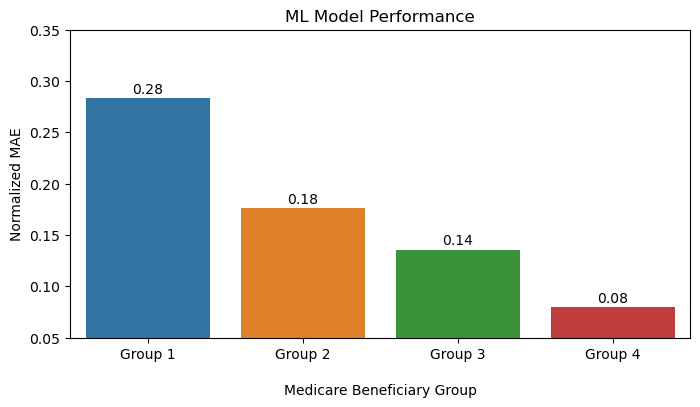

In [122]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x='Bene_MCC', y='MNMAE', data=df_grp_mae_rf, hue='Bene_MCC')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['Group 1', 'Group 2', 'Group 3', 'Group 4']);
plt.ylim([0.05, 0.35]);
plt.title("ML Model Performance")
# plt.xlabel("\nNumber of chronic conditions");
plt.xlabel("\nMedicare Beneficiary Group");
plt.ylabel("Normalized MAE");
plt.text(-0.1,df_grp_mae_rf.MNMAE[0]+0.005, f"{np.round(df_grp_mae_rf.MNMAE[0],2)}");
plt.text(0.9,df_grp_mae_rf.MNMAE[1]+0.005, f"{np.round(df_grp_mae_rf.MNMAE[1],2)}");
plt.text(1.9,df_grp_mae_rf.MNMAE[2]+0.005, f"{np.round(df_grp_mae_rf.MNMAE[2],2)}");
plt.text(2.9,df_grp_mae_rf.MNMAE[3]+0.005, f"{np.round(df_grp_mae_rf.MNMAE[3],2)}");

##### Prediction analysis

In [42]:
mcc_palette = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

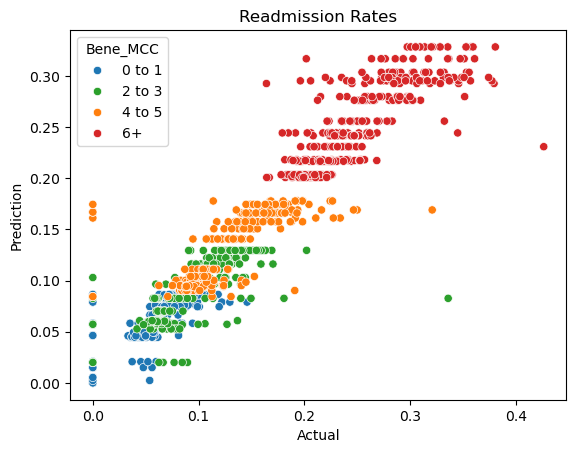

In [43]:
sns.scatterplot(x='Hosp_Readmsn_Rate', y='rf_pred', data=df_rf_res.sort_values('Bene_MCC'), hue='Bene_MCC', palette=mcc_palette);
plt.title("Readmission Rates")
plt.xlabel("Actual");
plt.ylabel("Prediction");

##### Error analysis

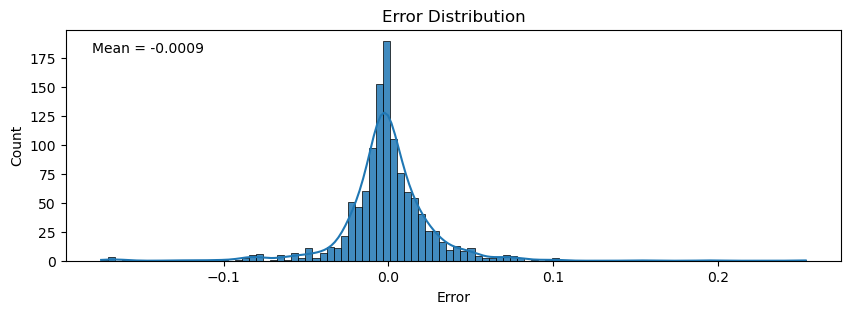

In [151]:
plt.figure(figsize=(10,3))
sns.histplot(x='rf_err', data=df_rf_res, kde=True, bins=100, alpha=0.85, edgecolor='black');
plt.text(-0.18,180, f'Mean = {np.round(df_rf_res.rf_err.mean(),4)}')
plt.title("Error Distribution")
plt.xlabel("Error");

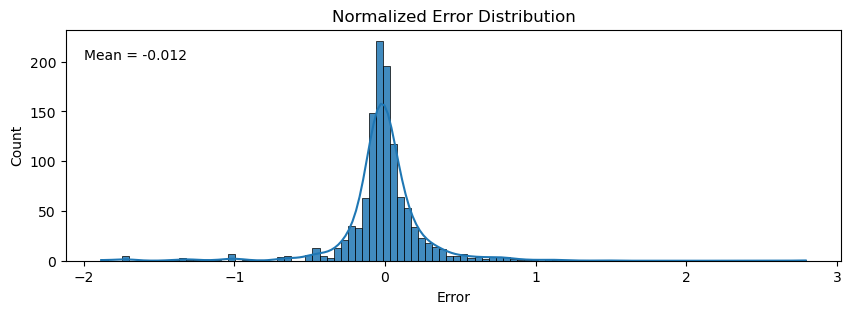

In [150]:
plt.figure(figsize=(10,3))
sns.histplot(x='rf_norm_err', data=df_rf_res, kde=True, bins=100, alpha=0.85, edgecolor='black');
plt.text(-2,202, f'Mean = {np.round(df_rf_res.rf_norm_err.mean(),4)}')
plt.title("Normalized Error Distribution")
plt.xlabel("Error");

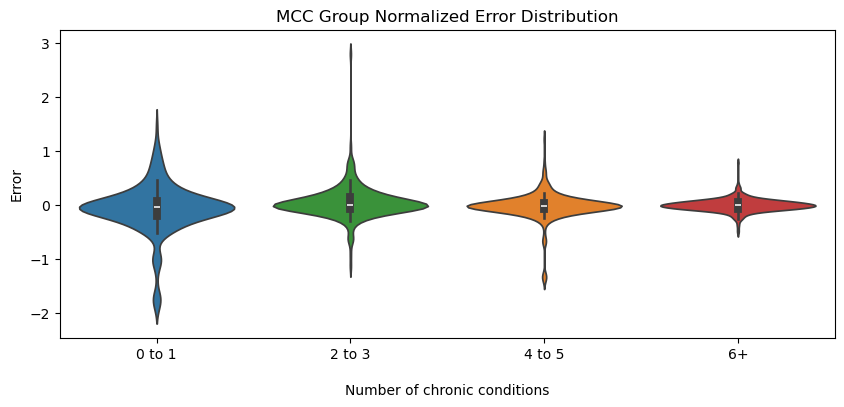

In [61]:
plt.figure(figsize=(10,4))
sns.violinplot(x='Bene_MCC', y='rf_norm_err', data=df_rf_res.sort_values('Bene_MCC'), hue='Bene_MCC', palette=mcc_palette);
plt.title("MCC Group Normalized Error Distribution")
plt.ylabel("Error")
plt.xlabel("\nNumber of chronic conditions");

In [132]:
df_grp_mae_rf

,Bene_MCC,MAE,MNMAE
0,0 to 1,0.013,0.283079
1,2 to 3,0.016,0.176200
2,4 to 5,0.017,0.135730
3,6+,0.020,0.079896


### Deriving prescriptive insights from ML modeling

##### Rank states by Readmission Ratio (Actual Readmission Rate/Predicted Readmission Rate)

In [107]:
df_grp_state_ratio = pd.DataFrame(df_rf_res.groupby('State')['Hosp_Readmsn_Rate'].mean()).reset_index()
df_grp_state_ratio['Readmission_Ratio'] = df_rf_res.groupby('State')['Hosp_Readmsn_Rate'].mean().values/df_rf_res.groupby('State')['rf_pred'].mean().values
df_grp_state_ratio.columns = ['State', 'Hosp_Readmsn_Rate', 'Readmission_Ratio']

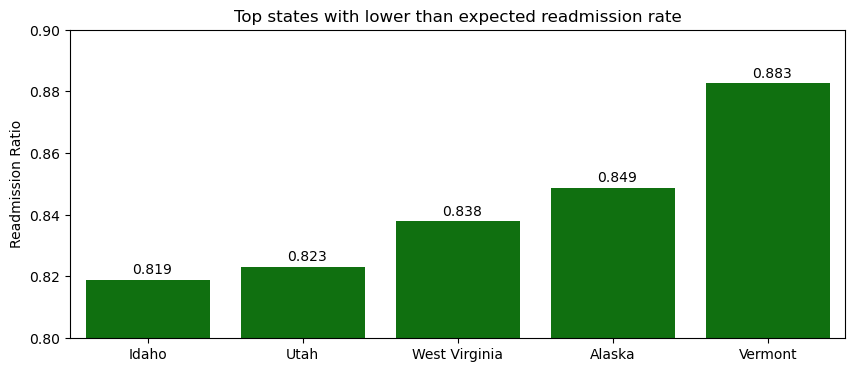

In [148]:
test_df = df_grp_state_ratio.sort_values('Readmission_Ratio')[:5]
plt.figure(figsize=(10,4))
sns.barplot(x='State', y='Readmission_Ratio', data=test_df, color='g');
plt.ylim([0.8,0.9])
# plt.gca().invert_yaxis();
plt.title("Top states with lower than expected readmission rate");
plt.xlabel(" ");
plt.ylabel("Readmission Ratio");
plt.text(-0.1,test_df.Readmission_Ratio.iloc[0]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[0],3)}");
plt.text(0.9,test_df.Readmission_Ratio.iloc[1]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[1],3)}");
plt.text(1.9,test_df.Readmission_Ratio.iloc[2]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[2],3)}");
plt.text(2.9,test_df.Readmission_Ratio.iloc[3]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[3],3)}");
plt.text(3.9,test_df.Readmission_Ratio.iloc[4]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[4],3)}");

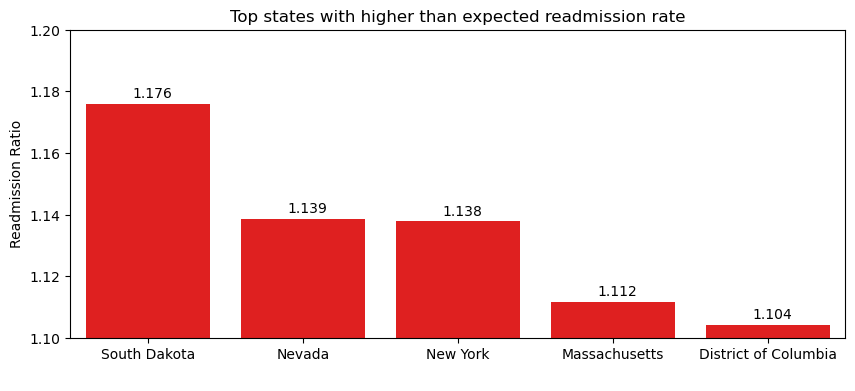

In [149]:
test_df = df_grp_state_ratio.sort_values('Readmission_Ratio', ascending=False)[:5]
plt.figure(figsize=(10,4))
sns.barplot(x='State', y='Readmission_Ratio', data=test_df, color='r');
plt.ylim([1.1,1.2]);
plt.title("Top states with higher than expected readmission rate")
plt.xlabel(" ");
plt.ylabel("Readmission Ratio");
plt.text(-0.1,test_df.Readmission_Ratio.iloc[0]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[0],3)}");
plt.text(0.9,test_df.Readmission_Ratio.iloc[1]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[1],3)}");
plt.text(1.9,test_df.Readmission_Ratio.iloc[2]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[2],3)}");
plt.text(2.9,test_df.Readmission_Ratio.iloc[3]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[3],3)}");
plt.text(3.9,test_df.Readmission_Ratio.iloc[4]+0.002, f"{np.round(test_df.Readmission_Ratio.iloc[4],3)}");

##### Rank states by mean deviation from expected readmission rate

In [104]:
df_grp_state_dev = pd.DataFrame(df_rf_res.groupby('State')['rf_err'].mean()).reset_index()
df_grp_state_dev.columns = ['State', 'Deviation']

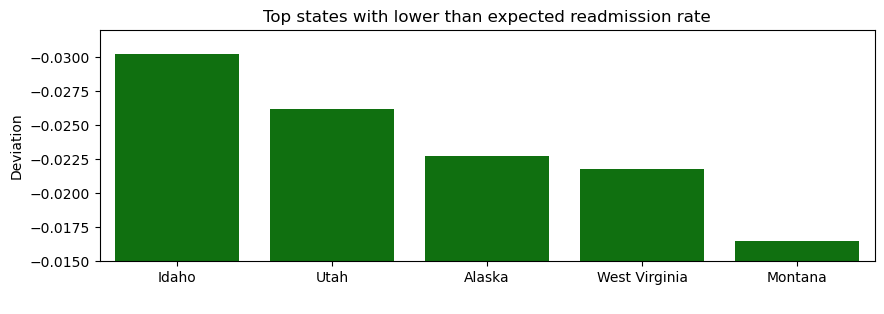

In [105]:
plt.figure(figsize=(10,3))
sns.barplot(x='State', y='Deviation', data=df_grp_state_dev.sort_values('Deviation')[:5], color='g');
plt.ylim([-0.032,-0.015])
plt.gca().invert_yaxis();
plt.title("Top states with lower than expected readmission rate");
plt.xlabel(" ");

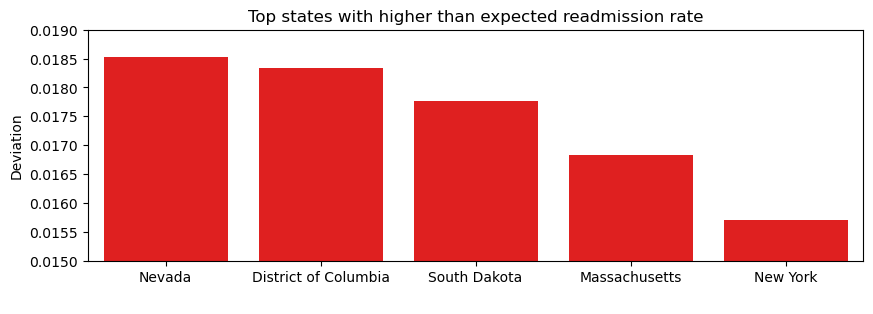

In [106]:
plt.figure(figsize=(10,3))
sns.barplot(x='State', y='Deviation', data=df_grp_state_dev.sort_values('Deviation', ascending=False)[:5], color='r');
plt.ylim([0.015,0.019]);
plt.title("Top states with higher than expected readmission rate")
plt.xlabel(" ");